# Hello!

The training time is under 5 min.
The training data size is set to minimum. I want to experiment easily without waiting for it to train for hours. You will get the main idea behind the paper with just enough data for a good enough working demo.

*Millad*

# Load data from github


In [9]:
import requests
all_reviews = []

url = 'https://raw.githubusercontent.com/Millad/easy_learning_from_label_proportions/refs/heads/main/data.json'
response = requests.get(url)

if response.status_code == 200:
    all_reviews = response.json()
    print("Loaded: " + str(len(all_reviews)) + " reviews")
else:
    print("Failed to retrieve the file:", response.status_code)

Loaded: 1215 reviews


# Training


TOTAL REVIEWS: 1215
total BAGS: 60
bag 0  ['delightful original film surprises clever twists', 'vibrant uplifting film inspires creative vision', 'truly inspiring cinematic experience layers meaning emotion', 'lifeless script flat execution make film hard recommend', 'dynamic engrossing film weaves intricate storytelling emotional depth', 'confusing project never quite manages hold together', 'refreshing tale charms original premise graceful execution', 'poorly conceived project fails engage due jumbled storyline', 'brilliant example storytelling captivates start finish', 'disappointing affair fails maintain momentum leaves audience disengaged', 'movie triumph direction performance', 'extraordinary piece cinema captivates beginning end', 'stirring narrative visually stunning emotionally resonant', 'utterly boring movie wouldnt recommend', 'moving inventive cinematic journey inspires every scene', 'rich layered film truly captivates audience', 'inspiring tale fills heart warmth joy', 'e

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


****
**** Going to start training with 5 epochs!
inside EPOCH loop!
Epoch 1/5 - Average Bag Loss: 0.3867
inside EPOCH loop!
Epoch 2/5 - Average Bag Loss: 0.2046
inside EPOCH loop!
Epoch 3/5 - Average Bag Loss: 0.0899
inside EPOCH loop!
Epoch 4/5 - Average Bag Loss: -0.0412
inside EPOCH loop!
Epoch 5/5 - Average Bag Loss: -0.3440


[Text(0.5, 1.0, 'Training Loss Over Time'),
 Text(0.5, 0, 'Epochs'),
 Text(0, 0.5, 'Loss')]

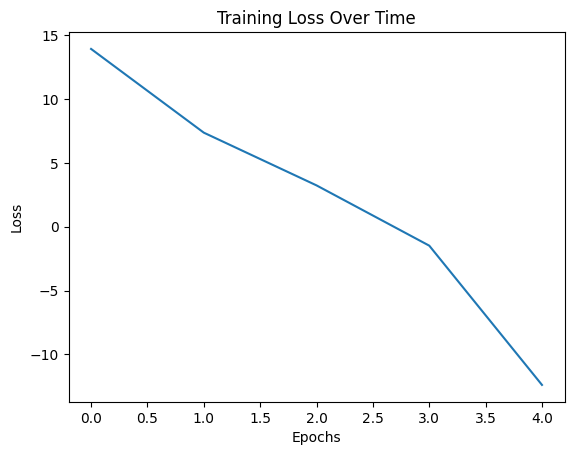

In [10]:
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score
import torch
import seaborn as sns
import pandas as pd
import numpy as np
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    words = text.split()
    stop_words = set([
        'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves',
        'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them',
        'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those',
        'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
        'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
        'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before',
        'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
        'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any',
        'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own',
        'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now'
    ])

    filtered_words = [word for word in words if word not in stop_words]
    processed_text = ' '.join(filtered_words)

    return processed_text

############# prepare bags for all reviews #############
random.shuffle(all_reviews)
print("TOTAL REVIEWS:", len(all_reviews))
bag_size = 20
bags = []

# Group reviews into bags of exactly bag_size.
for i in range(0, len(all_reviews), bag_size):
    bag_group = all_reviews[i:i+bag_size]
    if len(bag_group) == bag_size:  # only use full bags
        bag = {
            "reviews": [preprocess_text(entry["text"]) for entry in bag_group],
            "labels": [entry["label"] for entry in bag_group],
            "bag_proportion" : sum([entry["label"] for entry in bag_group]) / len([entry["label"] for entry in bag_group])
        }
        bags.append(bag)

print("total BAGS: " + str(len(bags)))
print("bag 0 ",bags[0]["reviews"])

########## train and test split ##########
np.random.shuffle(bags)
split_idx = int(0.6 * len(bags))  # 60% split index due to limited training data so we don't easily overfit on 80:20 split
train_bags, test_bags = bags[:split_idx], bags[split_idx:]

print("Train bags:", len(train_bags))
print("Test bags:", len(test_bags))

total_reviews = sum(len(bag["reviews"]) for bag in train_bags)
total_positive = sum(bag["bag_proportion"] * len(bag["reviews"]) for bag in train_bags)
p = total_positive / total_reviews  # population positive rate
print(f"Estimated population positive rate p = {p:.2f}")  # aim for ~0.50

###########  Tokenizer and model ##########
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)
model.train()

optimizer = AdamW(model.parameters(), lr=2e-5)

###########  EASYLLP loss function ##########
def easyllp_loss(y_pred, alpha, K, p):
    y_pred = y_pred.reshape(-1, K)  # new shape: (num_bags, K); here num_bags==1 per call.
    pos_losses = torch.mean((y_pred - 1)**2, dim=1)
    neg_losses = torch.mean((y_pred)**2, dim=1)
    loss = (K * (alpha - p) + p) * pos_losses + (K * (p - alpha) + (1 - p)) * neg_losses
    return loss.mean()

###########  Training ##########
losses = []
num_epochs = 5
print("****")
print(f"**** Going to start training with {num_epochs} epochs!")
for epoch in range(num_epochs):
    print("inside EPOCH loop!")
    total_loss = 0.0
    num_bags = 0

    for bag in train_bags:
        reviews = bag["reviews"]
        alpha = bag["bag_proportion"]  # current bag proportion
        k = len(reviews)  # K = bag size

        encoding = tokenizer(reviews, padding=True, truncation=True, return_tensors="pt")
        input_ids = encoding["input_ids"]
        attention_mask = encoding.get("attention_mask", None)

        y_pred = model(input_ids, attention_mask=attention_mask)
        logits = y_pred.logits.squeeze(-1)

        loss = easyllp_loss(logits, alpha, k, p) # p = population positive rate

        ### Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_bags += 1

    avg_loss = total_loss / num_bags
    losses.append(total_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Average Bag Loss: {avg_loss:.4f}")

###### PLOT loss ######
loss_df = pd.DataFrame({"Epoch": range(len(losses)), "Loss": losses})
sns.lineplot(data=loss_df, x="Epoch", y="Loss").set(
    title="Training Loss Over Time", xlabel="Epochs", ylabel="Loss"
)

# Eval model

In [11]:
model.eval()
actual_test_bags_predictions = []
with torch.no_grad():
    for bag in test_bags:
        reviews = bag["reviews"]
        alpha = bag["bag_proportion"]
        k = len(reviews)  # K = Bag size

        encoding = tokenizer(reviews, padding=True, truncation=True, return_tensors="pt")
        input_ids = encoding["input_ids"]
        attention_mask = encoding.get("attention_mask", None)

        y_pred = model(input_ids, attention_mask=attention_mask)
        logits = y_pred.logits.squeeze(-1)  # shape: (k,)
        preds = (logits >= 0.5).long()
        actual_test_bags_predictions.append(preds.tolist())

y_true = list(map(lambda bag: 1 if bag["bag_proportion"] >= 0.5 else 0, test_bags))
y_pred = [1 if np.mean(sub_array) >= 0.5 else 0 for sub_array in actual_test_bags_predictions]

print("Total test bags: ", len(test_bags))
print("Real Y Values for each bag   : ",y_true)
print("Predicted values for each bag: ",y_pred)

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

print(f'Bag-Level Accuracy: {accuracy * 100:.2f}%')
print(f'Bag-Level F1-score: {f1:.4f}')

Total test bags:  24
Real Y Values for each bag   :  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]
Predicted values for each bag:  [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1]
Bag-Level Accuracy: 83.33%
Bag-Level F1-score: 0.8370


In [12]:
# Manual test.... try for yourself!
with torch.no_grad():
  examp_review_pos = 'This movie is awesome. I love every bit of it! What an experience!'
  examp_review_neg = "I hated the moive. It was very boring!"
  example_other = 'Write your own text to test out'
  txt = preprocess_text(examp_review_pos)
  print(txt)

  encoding = tokenizer(txt, padding=True, truncation=True, return_tensors="pt")
  input_ids = encoding["input_ids"]
  attention_mask = encoding.get("attention_mask", None)

  y_pred = model(input_ids, attention_mask=attention_mask)
  logits = y_pred.logits.squeeze(-1)

  preds = (logits >= 0.5).long()
  print("POSITIVE" if preds.item() == 1 else "NEGATIVE")
  print(logits.item())


movie awesome love every bit experience
POSITIVE
0.6673760414123535
